Blackrock's Python Documentation: https://blackrockneurotech.com/research/wp-content/ifu/LB-0826-1.11-Python-Offline-Utilities-IFU-Draft.pdf

Blackrock's Matlab Documentation: https://github.com/BlackrockNeurotech/NPMK/blob/master/NPMK/Users%20Guide.pdf

Blackrock's Github: https://github.com/BlackrockNeurotech/Python-Utilities

Here I extract the data that is necessary to populate the sessions and threshold_files tables. The sessions table requires the following fields:
- day_key  - DONE
- rec_time
- sessions_key
- paper_key
- behavior_notes
- behavior_quality
- other_notes
- task_id
- lab_num
- duration
- numChannels
- hasTriggers
- hasChaoticLoad
- hasBumps - check with kevin for encoding
- numTrials
- numReward - DONE
- numAbort - DONE
- numFail - DONE
- numIncomplete - DONE
- reward_size

The threshold_files table requires the following fields:
- sessions_key
- array_serial
- paper_key
- filename
- file_id
- setting_file
- is_sorted
- sorted_by
- num_chans
- num_units
- rec_system
- connect_type
- connect_serial
- threshold_quality
- threshold_notes

In [1]:
# Import dependencies
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from os import path, system
import sys
from sys import platform
import glob
from scipy import signal
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import time
# from PyQt5.QtWidgets import QFileDialog

# brpylib is the module that contains functions/classes that allow us to open and extract data from .nev and .nsx files
from Python_Utilities import brpylib
from Python_Utilities import brMiscFxns

# Scrape directory and put file names into lists

In [2]:
# Monkey data
monkeyName = "Greyson"
ccmID = "18E2"

# directory info
scrape_dir = '/Volumes/L_MillerLab/data/Greyson_17L2/CerebusData'
if not path.exists(scrape_dir):
    print(f"{scrape_dir} does not exist! Try again!")

In [3]:
%%time
nev_list = glob.glob(f"{scrape_dir}/*/*.nev")
nsx_list = glob.glob(f"{scrape_dir}/*/*.ns*")
# plx_list = glob.glob(f"{scrape_dir}/*/*.plx")
# ccf_list = glob.glob(f"{scrape_dir}/*/*.ccf")

CPU times: user 58.4 ms, sys: 119 ms, total: 177 ms
Wall time: 6.31 s


In [4]:
len(nev_list), len(nsx_list), #len(plx_list), len(ccf_list)

(322, 260)

In [5]:
nev_list[0], nsx_list[0]

('/Volumes/L_MillerLab/data/Greyson_17L2/CerebusData/20181220/20181220_Greyson_FreeReaching_001.nev',
 '/Volumes/L_MillerLab/data/Greyson_17L2/CerebusData/20181220/20181220_Greyson_PG_001.ns3')

In [8]:
nev_list[0][60:-4]

'20181220_Greyson_FreeReaching_001'

In [11]:
nev_list_fnames = [fname[60:-4] for fname in nev_list]
nsx_list_fnames = [fname[60:-4] for fname in nsx_list]

In [23]:
nev_nsx = []
nsx_nev = []
for fname in nev_list_fnames:
    if fname in nsx_list_fnames:
        nev_nsx.append(fname)
for fname in nsx_list_fnames:
    if fname in nev_list_fnames:
        nsx_nev.append(fname)

In [24]:
len(nev_nsx), len(nsx_nev)

(259, 260)

## Nev File exploration

### Compare time it takes to read from server vs copying locally and then loading

#### From  server

In [8]:
# create one NEV File object
open_extract_server_files = []
for i in range(20):
    start = time.time()
    NevFileObj = brpylib.NevFile(nev_list[1])
    end1 = time.time()
    print("total time taken to open file: ", end1 - start)
    output = NevFileObj.getdata(elec_ids='all')
    end2 = time.time()
    print("total time taken to extract file data: ", end2 - end1)
    open_extract_server_files.append(end2-start)


20181220_Greyson_PG_001.nev opened
total time taken to open file:  0.1470646858215332
total time taken to extract file data:  158.48820614814758

20181220_Greyson_PG_001.nev opened
total time taken to open file:  0.5008480548858643
total time taken to extract file data:  72.9266140460968

20181220_Greyson_PG_001.nev opened
total time taken to open file:  0.22360682487487793
total time taken to extract file data:  70.55444812774658

20181220_Greyson_PG_001.nev opened
total time taken to open file:  0.21303200721740723
total time taken to extract file data:  72.02680325508118

20181220_Greyson_PG_001.nev opened
total time taken to open file:  0.1834559440612793
total time taken to extract file data:  68.69132113456726

20181220_Greyson_PG_001.nev opened
total time taken to open file:  1.0721611976623535
total time taken to extract file data:  72.90764474868774

20181220_Greyson_PG_001.nev opened
total time taken to open file:  0.45429301261901855
total time taken to extract file data:  

In [10]:
copy_open_extract_local_files = []
for i in range(20):
    start = time.time()
    !scp '/Volumes/L_MillerLab/data/Greyson_17L2/CerebusData/20181220/20181220_Greyson_PG_001.nev' '/Users/aajanquail/Desktop/Jupyter_Notebooks/Miller_Lab/Database_Migration/20181220_Greyson_PG_001.nev'
    end0 = time.time()
    print("total time taken to copy file: ", end0 - start)
    NevFileObj = brpylib.NevFile('/Users/aajanquail/Desktop/Jupyter_Notebooks/Miller_Lab/Database_Migration/20181220_Greyson_PG_001.nev')
    end1 = time.time()
    print("total time taken to open file: ", end1 - end0)
    output = NevFileObj.getdata(elec_ids='all')
    end2 = time.time()
    print("total time taken to extract file data: ", end2 - end1)
    !rm '/Users/aajanquail/Desktop/Jupyter_Notebooks/Miller_Lab/Database_Migration/20181220_Greyson_PG_001.nev'
    end3 = time.time()
    print("total time taken to remove file: ", end3 - end2)
    copy_open_extract_local_files.append(end2-start)

^C
total time taken to copy file:  20.26966094970703

20181220_Greyson_PG_001.nev opened
total time taken to open file:  0.015027999877929688


KeyboardInterrupt: 

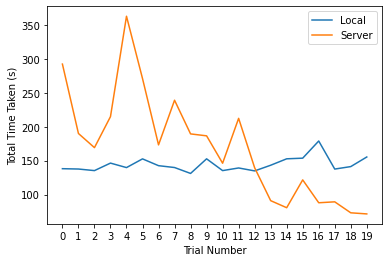

In [30]:
x1 = np.arange(len(copy_open_extract_local_files))
x2 = np.arange(len(open_extract_server_files))
plt.xticks(x)
plt.xlabel('Trial Number')
plt.ylabel('Total Time Taken (s)')
plt.plot(x1,copy_open_extract_local_files, label='Local')
plt.plot(x2,open_extract_server_files, label = 'Server')
plt.legend()
plt.show()

### Single File examination

Getting the data from a single NEV File object takes quite some time... May be due to the fact that older files are put into cold storage and thus take longer to retrieve.

In [5]:
nev_list

['/Volumes/L_MillerLab/data/Greyson_17L2/CerebusData/20181220/20181220_Greyson_FreeReaching_001.nev',
 '/Volumes/L_MillerLab/data/Greyson_17L2/CerebusData/20181220/20181220_Greyson_PG_001.nev',
 '/Volumes/L_MillerLab/data/Greyson_17L2/CerebusData/20181205/20181205_Greyson_PG_002.nev',
 '/Volumes/L_MillerLab/data/Greyson_17L2/CerebusData/20181205/20181205_Greyson_PG_001.nev',
 '/Volumes/L_MillerLab/data/Greyson_17L2/CerebusData/20200213/20200213_Greyson_Cage_003003.nev',
 '/Volumes/L_MillerLab/data/Greyson_17L2/CerebusData/20200213/20200213_Greyson_Cage_005005.nev',
 '/Volumes/L_MillerLab/data/Greyson_17L2/CerebusData/20200213/20200213_Greyson_Cage_010010.nev',
 '/Volumes/L_MillerLab/data/Greyson_17L2/CerebusData/20200213/20200213_Greyson_Cage_004004.nev',
 '/Volumes/L_MillerLab/data/Greyson_17L2/CerebusData/20200213/20200213_Greyson_Cage_016016.nev',
 '/Volumes/L_MillerLab/data/Greyson_17L2/CerebusData/20200213/20200213_Greyson_Cage_007007.nev',
 '/Volumes/L_MillerLab/data/Greyson_17L2

In [6]:
nev_folder_date_list = sorted([nev_list[i][51:59] for i in range(len(nev_list))])

In [7]:
nev_folder_date_list

['20180810',
 '20180810',
 '20180810',
 '20180810',
 '20180830',
 '20180830',
 '20180830',
 '20180831',
 '20180831',
 '20180831',
 '20180906',
 '20180906',
 '20180906',
 '20180907',
 '20180907',
 '20180907',
 '20180907',
 '20180910',
 '20180910',
 '20180926',
 '20180926',
 '20180927',
 '20180927',
 '20180928',
 '20180928',
 '20180928',
 '20180928',
 '20181003',
 '20181003',
 '20181005',
 '20181005',
 '20181005',
 '20181009',
 '20181011',
 '20181011',
 '20181011',
 '20181011',
 '20181011',
 '20181011',
 '20181011',
 '20181011',
 '20181011',
 '20181011',
 '20181011',
 '20181011',
 '20181011',
 '20181011',
 '20181017',
 '20181017',
 '20181017',
 '20181107',
 '20181112',
 '20181112',
 '20181112',
 '20181112',
 '20181113',
 '20181113',
 '20181113',
 '20181114',
 '20181114',
 '20181114',
 '20181114',
 '20181115',
 '20181115',
 '20181116',
 '20181116',
 '20181116',
 '20181116',
 '20181116',
 '20181116',
 '20181116',
 '20181119',
 '20181120',
 '20181120',
 '20181120',
 '20181121',
 '20181121',

In [8]:
nev_file_date_list = []
for i in range(len(nev_list)):
    nevobj = brpylib.NevFile(nev_list[i])
    dt = str(nevobj.basic_header['TimeOrigin'].date()).replace('-','')
    nev_file_date_list.append(dt)


20181220_Greyson_FreeReaching_001.nev opened

20181220_Greyson_PG_001.nev opened

20181205_Greyson_PG_002.nev opened

20181205_Greyson_PG_001.nev opened

20200213_Greyson_Cage_003003.nev opened

20200213_Greyson_Cage_005005.nev opened

20200213_Greyson_Cage_010010.nev opened

20200213_Greyson_Cage_004004.nev opened

20200213_Greyson_Cage_016016.nev opened

20200213_Greyson_Cage_007007.nev opened

20200213_Greyson_Cage_006006.nev opened

20200213_Greyson_Cage_011011.nev opened

20200213_Greyson_Cage_001001.nev opened

20200213_Greyson_Cage_015015.nev opened

20200213_Greyson_Cage_014014.nev opened

20200213_Greyson_Cage_009009.nev opened

20200213_Greyson_Cage_002002.nev opened

20200213_Greyson_Cage_012012.nev opened

20200213_Greyson_Cage_008008.nev opened

20200213_Greyson_Cage_013013.nev opened

20181130_Greyson_PG_002.nev opened

20181130_Greyson_PG_001.nev opened

20181121_Greyson_PG_002.nev opened

20181121_Greyson_PG_003.nev opened

20181121_Greyson_PG_001.nev opened

20190910_

TypeError: stat: path should be string, bytes, os.PathLike or integer, not tuple

# Obtain Fields

**Nev obj structure**

It has three main attributes/functions: basic_header, getdata(), extended_headers. The documentation mentions others, such as processroicommments(), but the files we have do not have those.

nevobj.basic_header returns a dictionary with the following keys/values:
- **key**: 'FileTypeID', **value**: str (e.g. 'NEURALEV')
- **key**: 'FileSpec', **value**: str with float (e.g. '2.3')
- **key**: 'AddFlags', **value**: int (likely bool 1/0)
- **key**: 'BytesInHeader', **value**: int
- **key**: 'BytesInDataPackets', **value**: int
- **key**: 'TimeStampResolution', **value**: int
- **key**: 'SampleTimeResolution', **value**: int
- **key**: 'TimeOrigin', **value**: datetime.datetime
- **key**: 'CreatingApplication', **value**: str (e.g. 'File Dialog v7.0.4')
- **key**: 'Comment', **value**: str
- **key**: 'NumExtendedHeaders', **value**: int

nevobj.getdata() takes a long time and returns a dictionary with the following structure:
- **key**: spike_events, **value**: dict
    - **key**: TimeStamps, **value**: list
        - A list of times (integers) in ascending order at which spikes occur (**note**: this is NOT the same as the total duration of the session)
        - The length of this list should, in theory, equal the number of spikes (aka threshold crossings)
    - **key**: Unit, **value**: list
        - A list whose length is equal to Timestamps. In all files I've opened, this list contains only 0s
    - **key**: Channel, **value**: list
        - A list that contains the channel number that corresponds to the spike event time in TimeStamps
        - If the first entry of Timestamps is 30 and the first entry of Channel is 2, that means that a spike occurred in channel 2 at time 30
    - **key**: Waveforms, ****value****: array
        - Array shape: num timestamps x num channels
        - The columns of this array contain the activity of the corresponding channel
- **key**: digital_events, **value**: dict (**note: not all files have digital_events**)
    - **key**: Timestamps, **value**: list
        - Not the same timestamps as spike_events. Different lengths and values.
    - **key**: InsertionReason, **value**: list
        - A list whose length is equal to Timestamps. In all files I've opened, this list contains only 1s
    - **key**: UnparsedData, **value**: list
        - A list with integers that encode various task- and trial-related information. Details can be found here:  https://github.com/limblab/Behavior/blob/master/src/target/words.h
        
nevobj.extended_headers returns a list of dicts; the number of dicts equals 'NumExtendedHeaders' in nevobj.basic_headers. 3 dicts in a row correspond to one electrode and contain the following info:
- dict1
    - **key**: 'PacketID':, **value**: str (e.g. 'NEUEVWAV')
    - **key**: 'ElectrodeID':, **value**:  int
    - **key**: 'PhysicalConnector':, **value**: int
    - **key**: 'ConnectorPin':, **value**:  int,
    - **key**: 'DigitizationFactor':, **value**:  int,
    - **key**: 'EnergyThreshold':, **value**:  int,
    - **key**: 'HighThreshold':, **value**:  int,
    - **key**: 'LowThreshold':, **value**:  int,
    - **key**: 'NumSortedUnits':, **value**:  int,
    - **key**: 'BytesPerWaveform':, **value**:  int,
    - **key**: 'SpikeWidthSamples':, **value**:  int,
    - **key**: 'EmptyBytes':, **value**: bytes
- dict2: electrode number
    - **key**: PacketID:, **value**: str 'NEUEVLBL'
    - **key**: ElectrodeID:, **value**: int (e.g. 1, should correspond to dict1)
    - **key**: Label:, **value**: str (the actual electrode number - e.g. 'elec78')
    - **key**: EmptyBytes:, **value**:  bytes (e.g. b'\x00\x00\x00\x00\x00\x00')
- dict3: filter information (type, frequency)
    - **key**: PacketID, **value**: str (e.g. 'NEUEVFLT')
    - **key**: ElectrodeID, **value**: int (e.g. 1, should corresond to dicts 1,2)
    - **key**: HighFreqCorner, **value**: str with float (e.g. '250.0 Hz')
    - **key**: HighFreqOrder, **value**: int (e.g. 4),
    - **key**: HighFreqType, **value**: str (e.g. 'butterworth')
    - **key**: LowFreqCorner, **value**: str with float (e.g. '7500.0 Hz')
    - **key**: LowFreqOrder, **value**: int (e.g. 3)
    - **key**: LowFreqType, **value**: str (e.g. 'butterworth')
    - **key**: EmptyBytes, **value**: bytes
        
**Nsx obj structure**

nsxobj.getdata() takes a few seconds a dict with the following structure:
- **key**: elec_ids, **value**: list
    - List of electrode id's
- **key**: start_time_s, **value**: float
    - Usually 0.
- **key**: data_time_s, **value**: str
    - In all of the files I've opened, this string has been 'all'.
- **key**: downsample, **value**: int
    - Likely boolean - 1s or 0s. In all the files I've opened, it's been 1.
- **key**: data, **value**: list
    - A list containing an array.
- **key**: data_headers, **value**: list whose only element is a dict
    - **key**: Timestamp, **value**: int (always 0 from what I've seen)
    - **key**: NumDataPoints, **value**: int (with number of total data points - should equal time length of file times sampling rate)
- **key**: ExtendedHeaderIndices, **value**: list

https://github.com/limblab/Behavior/blob/master/src/target/words.h

In [8]:
# day_key - DONE
# rec_time - DONE
# sessions_key
# paper_key
# behavior_notes
# behavior_quality
# other_notes
# task_id
# lab_num
# duration
# numChannels
# hasTriggers # leave nan - if you don't fill in it should be nan
# hasChaoticLoad # leave nan - if you don't fill in it should be nan
# hasBumps - check with kevin for encoding
# numTrials - DONE
# numReward - DONE
# numAbort - DONE
# numFail - DONE
# numIncomplete - DONE
# reward_size

In [9]:
day_key = [] #done
rec_time = [] #done
sessions_key = [] #obtain from sessions table
paper_key = [] #leave nan - reference for which papers have used this data
behavior_notes = [] #Information from daily log - something clever?
behavior_quality = [] #Information from daily log - something clever?
other_notes = [] #Information from daily log
task_id = [] # target words #define WORD_TASK_CODE 0x02
lab_num = [] # Daily Log 
duration = [] #check nev - should be in metadata
numChannels = [] #check nev - unique entries inside threshold
hasTriggers = [] #leave nan - if you don't fill in it should be nan
hasChaoticLoad = [] #leave nan - if you don't fill in it should be nan
hasBumps = [] #word_bump?
numTrials = [] #done
numReward = [] #done
numAbort = [] #done
numFail = [] #done
numIncomplete = [] #done
reward_size = [] #leave blank for now, fill in as we go through daily logs

In [18]:
# create one NEV File object
shortened_nev_list = [nev_list[0]]
for nev_filename in shortened_nev_list:
    # open file
    nevobj = brpylib.NevFile(nev_filename)
    
    # check that date in filename is same as date in basic header, if so append to day_key
    filname_date = nev_filename[51:59]
    dt = str(nevobj.basic_header['TimeOrigin'].date()).replace('-','')
    assert filname_date == dt
    #note that appending filename_date is a placeholder - should be of type int(11)
    day_key.append(filename_date)
    rt = str(nevobj.basic_header['TimeOrigin'].time())
    rec_time.append(rt)
    
    output = nevobj.getdata(elec_ids='all')
    
    words = {'reward':0x20, 'abort': 0x21, 'fail': 0x22, 'incomp':0x23, 'trials':0x30}
    words_count = {'reward':0, 'abort': 0, 'fail': 0, 'incomp':0, 'trials':0}

    for word,code in words.items():
        n_events = np.sum([((out & 0xFF00) >> 8)==code for out in output['digital_events']['UnparsedData']])
        words_count[word] += n_events
    numReward.append(words_count['reward'])
    numAbort.append(words_count['abort'])
    numFail.append(words_count['fail'])
    numIncomplete.append(words_count['incomp'])
    numTrials.append(words_count['trials'])


20181220_Greyson_FreeReaching_001.nev opened


In [33]:
nevobj = brpylib.NevFile(nev_list[0])
output = nevobj.getdata(elec_ids='all')
output['digital_events']['UnparsedData']
np.sum([((out & 0xFF00) >> 8)==0x02 for out in output['digital_events']['UnparsedData']])


20181220_Greyson_FreeReaching_001.nev opened


0

In [36]:
nevobj.basic_header

{'FileTypeID': 'NEURALEV',
 'FileSpec': '2.3',
 'AddFlags': 1,
 'BytesInHeader': 26512,
 'BytesInDataPackets': 104,
 'TimeStampResolution': 30000,
 'SampleTimeResolution': 30000,
 'TimeOrigin': datetime.datetime(2018, 12, 20, 17, 6, 59, 781000),
 'CreatingApplication': 'File Dialog v7.0.4',
 'Comment': '',
 'NumExtendedHeaders': 818}

In [41]:
[(i, type(nevobj.basic_header[i])) for i in nevobj.basic_header]

[('FileTypeID', str),
 ('FileSpec', str),
 ('AddFlags', int),
 ('BytesInHeader', int),
 ('BytesInDataPackets', int),
 ('TimeStampResolution', int),
 ('SampleTimeResolution', int),
 ('TimeOrigin', datetime.datetime),
 ('CreatingApplication', str),
 ('Comment', str),
 ('NumExtendedHeaders', int)]

In [79]:
str(NevFileObj.basic_header['TimeOrigin'].date()).replace('-','')

'20181220'

Examining Spike Events. Waveforms array (shape (426190, 96)) contains 96 copies of the EXACT SAME signal. Confirmed this by looking at individual rows of waveform and getting distinct values in each row (each row had 1 distinct value).

In [35]:
len(output['spike_events'])

4

In [52]:
len(output['spike_events']['TimeStamps']), type(output['spike_events']['TimeStamps'])

(426190, list)

In [53]:
len(output['spike_events']['Unit']), type(output['spike_events']['Unit'])

(426190, list)

In [54]:
len(output['spike_events']['Channel']), type(output['spike_events']['Channel'])

(426190, list)

In [55]:
np.unique(output['spike_events']['Channel'])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96], dtype=uint16)

In [56]:
output['spike_events']['Waveforms'].shape, type(output['spike_events']['Waveforms'])

((426190, 96), numpy.ndarray)

In [58]:
brMiscFxns.checkequal(output['spike_events']['Waveforms'][0,:])

True

In [59]:
brMiscFxns.checkequal(output['spike_events']['Waveforms'][0])

True

#### Digital Events

In [32]:
tasks = {'CO':0x01, 'RW':0x02, 'FC':0x03, 'MG':0x06, 'WF':0x07}
# for task,code in tasks.items():
#     n_events = np.sum([((out & 0xFF00) >> 8)< for out in output['digital_events']['UnparsedData']])
#     print(f"{task}: {n_events}")

np.unique([((out & 0xFF00) >> 8) for out in output['digital_events']['UnparsedData'] if ((out & 0xFF00) >> 8)<0x10])

#if TASK_CO
#define WORD_TASK_CODE 0x01
#elif TASK_RW
#define WORD_TASK_CODE 0x02
#elif TASK_FC
#define WORD_TASK_CODE 0x03
#elif TASK_MG
#define WORD_TASK_CODE 0x06
#elif TASK_WF
#define WORD_TASK_CODE 0x07
#elif TASK_UC || TASK_UN || TASK_UN1D
#define WORD_TASK_CODE 0x08
#elif TASK_BD
#define WORD_TASK_CODE 0x09
#elif TASK_BC
#define WORD_TASK_CODE 0x0A
#elif TASK_VS
#define WORD_TASK_CODE 0x0B
#elif TASK_BF
#define WORD_TASK_CODE 0x0C
#elif TASK_2AFC
#define WORD_TASK_CODE 0x0D
#elif TASK_AT
#define WORD_TASK_CODE 0x0E
#elif TASK_DB_DEFINED
#define WORD_TASK_CODE 0x0F /* this is an escape indicating that the task will be specified by the databurst */
#endif

NameError: name 'output' is not defined

In [ ]:
# 0xFF00 keeps the first 8 bits 
# out & 0xFF00 finds the first 8 bits of out
# >> 8 shifts it over by 8 bits
# out is in integer that encodes important information
temp_list = [((out & 0xFF00) >> 8) for out in output['digital_events']['UnparsedData']]
has_bumps = np.any(np.isin(temp_list, np.arange(0x50,0x5F)))

## Nsx file explortation

nsx file sampling rates:
- 1: 500
- 2: 1000
- 3: 2000
- 4: 10000
- 5: 30000
- 6: 30000 (raw)

In [13]:
nsxfileobjs = []
for nsx_file in nsx_list[1:2]:
    NsxFileObj = brpylib.NsxFile(nsx_file)
    nsxfileobjs.append(NsxFileObj.getdata())


20181220_Greyson_FreeReaching_001.ns3 opened


In [20]:
_20181220_Greyson_FreeReaching_001_ns3 = brpylib.NsxFile(nsx_file)


20181220_Greyson_FreeReaching_001.ns3 opened


In [21]:
_20181220_Greyson_FreeReaching_001_ns3.basic_header

{'FileTypeID': 'NEURALCD',
 'FileSpec': '2.3',
 'BytesInHeader': 1238,
 'Label': '2 kS/s',
 'Comment': '',
 'Period': 15,
 'TimeStampResolution': 30000,
 'TimeOrigin': datetime.datetime(2018, 12, 20, 17, 6, 59, 785000),
 'ChannelCount': 14}

In [23]:
_20181220_Greyson_FreeReaching_001_ns3.extended_headers

[{'Type': 'CC',
  'ElectrodeID': 257,
  'ElectrodeLabel': 'EMG_FDP2',
  'PhysicalConnector': 9,
  'ConnectorPin': 1,
  'MinDigitalValue': -32767,
  'MaxDigitalValue': 32767,
  'MinAnalogValue': -5000,
  'MaxAnalogValue': 5000,
  'Units': 'mV',
  'HighFreqCorner': '10.0 Hz',
  'HighFreqOrder': 2,
  'HighFreqType': 'butterworth',
  'LowFreqCorner': '250.0 Hz',
  'LowFreqOrder': 2,
  'LowFreqType': 'butterworth'},
 {'Type': 'CC',
  'ElectrodeID': 258,
  'ElectrodeLabel': 'EMG_FCU1',
  'PhysicalConnector': 9,
  'ConnectorPin': 2,
  'MinDigitalValue': -32767,
  'MaxDigitalValue': 32767,
  'MinAnalogValue': -5000,
  'MaxAnalogValue': 5000,
  'Units': 'mV',
  'HighFreqCorner': '10.0 Hz',
  'HighFreqOrder': 2,
  'HighFreqType': 'butterworth',
  'LowFreqCorner': '250.0 Hz',
  'LowFreqOrder': 2,
  'LowFreqType': 'butterworth'},
 {'Type': 'CC',
  'ElectrodeID': 259,
  'ElectrodeLabel': 'EMG_FCR1',
  'PhysicalConnector': 9,
  'ConnectorPin': 3,
  'MinDigitalValue': -32767,
  'MaxDigitalValue': 327

In [14]:
len(nsxfileobjs)

1

In [15]:
output_nsx = nsxfileobjs[0]

In [16]:
type(output_nsx)

dict

In [17]:
[(i, type(output_nsx[i])) for i in output_nsx]

[('elec_ids', list),
 ('start_time_s', float),
 ('data_time_s', str),
 ('downsample', int),
 ('data', list),
 ('data_headers', list),
 ('ExtendedHeaderIndices', list)]


- **key**: data, **value**: list
- **key**: data_headers, **value**: list
- **key**: ExtendedHeaderIndices, **value**: list

In [39]:
nsxfileobjs[0]

In [45]:
# 14 electrodes
for o in nsxfileobjs:
    print(o['elec_ids'], len(o['elec_ids']))

[257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 271, 272] 14
[257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 271, 272] 14
[257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 271, 272] 14
[257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 271, 272] 14
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96] 96
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 8

In [34]:
len(output_nsx['data']), type(output_nsx['data'][0])

(1, numpy.ndarray)

In [ ]:
nsxfileobjs

14 electrodes, 1800020 data points

In [18]:
output_nsx['data'][0].shape

(1200020, 14)

In [19]:
output_nsx['data_headers']

[{'Timestamp': 0, 'NumDataPoints': 1200020}]

In [87]:
output_nsx['ExtendedHeaderIndices']

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

nsx file extended headers contain information on each of the 14 electrodes, including id, electrode label, high and low frequency type

In [106]:
NsxFileObj.extended_headers

[{'Type': 'CC',
  'ElectrodeID': 257,
  'ElectrodeLabel': 'EMG_FDP2',
  'PhysicalConnector': 9,
  'ConnectorPin': 1,
  'MinDigitalValue': -32767,
  'MaxDigitalValue': 32767,
  'MinAnalogValue': -5000,
  'MaxAnalogValue': 5000,
  'Units': 'mV',
  'HighFreqCorner': '10.0 Hz',
  'HighFreqOrder': 2,
  'HighFreqType': 'butterworth',
  'LowFreqCorner': '250.0 Hz',
  'LowFreqOrder': 2,
  'LowFreqType': 'butterworth'},
 {'Type': 'CC',
  'ElectrodeID': 258,
  'ElectrodeLabel': 'EMG_FCU1',
  'PhysicalConnector': 9,
  'ConnectorPin': 2,
  'MinDigitalValue': -32767,
  'MaxDigitalValue': 32767,
  'MinAnalogValue': -5000,
  'MaxAnalogValue': 5000,
  'Units': 'mV',
  'HighFreqCorner': '10.0 Hz',
  'HighFreqOrder': 2,
  'HighFreqType': 'butterworth',
  'LowFreqCorner': '250.0 Hz',
  'LowFreqOrder': 2,
  'LowFreqType': 'butterworth'},
 {'Type': 'CC',
  'ElectrodeID': 259,
  'ElectrodeLabel': 'EMG_FCR1',
  'PhysicalConnector': 9,
  'ConnectorPin': 3,
  'MinDigitalValue': -32767,
  'MaxDigitalValue': 327

Plot ns3 stuff

Channel: 257


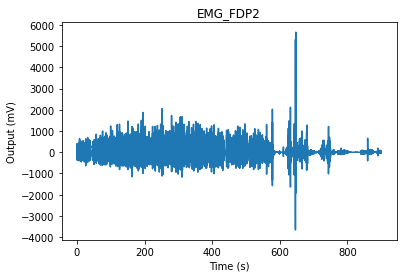

Channel: 258


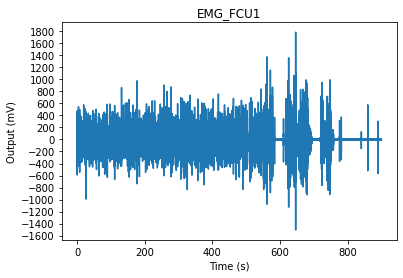

Channel: 259


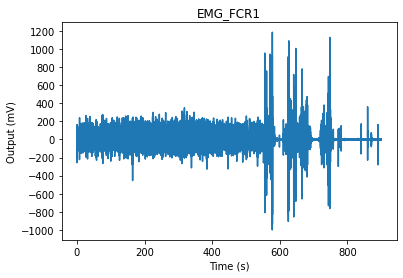

Channel: 260


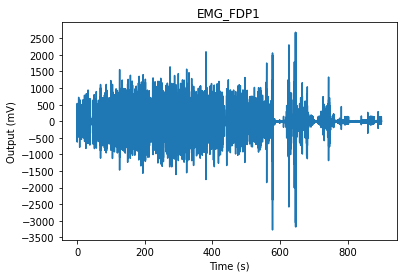

Channel: 261


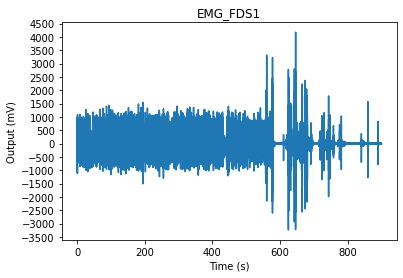

Channel: 262


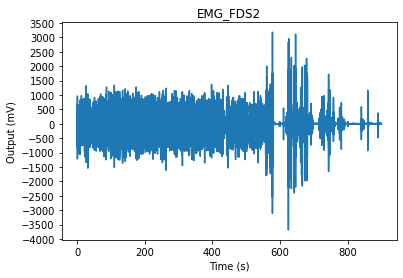

Channel: 263


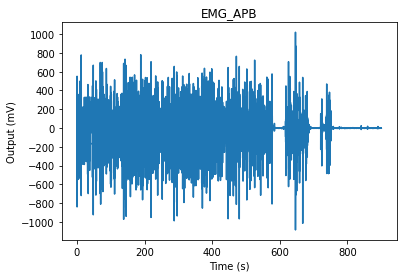

Channel: 264


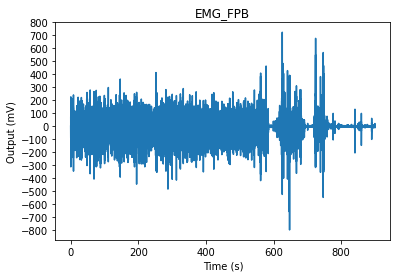

Channel: 265


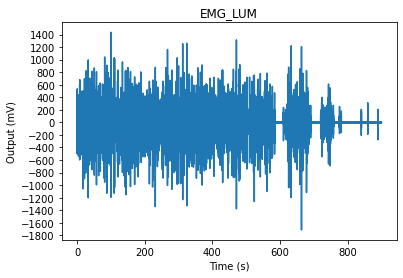

Channel: 266


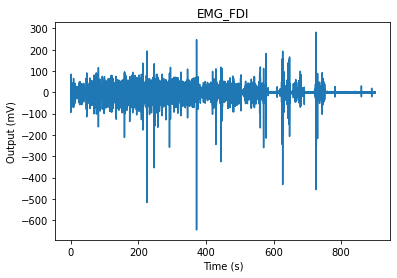

Channel: 267


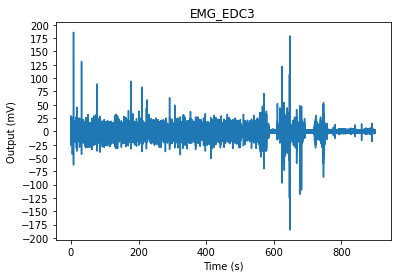

Channel: 268


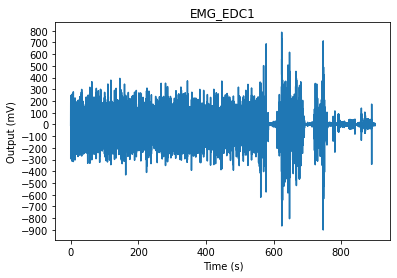

Channel: 271


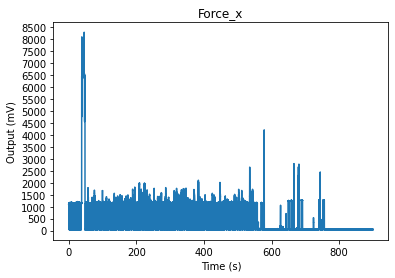

Channel: 272


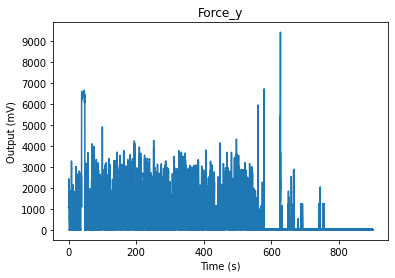

In [101]:
for plot_chan in output_nsx['elec_ids']:

    ch_idx  = output_nsx['elec_ids'].index(plot_chan)
    print('Channel: '+str(plot_chan))
    hdr_idx = output_nsx['ExtendedHeaderIndices'][ch_idx]
    # Bug in the original code - changed np.arange(output_nsx['data'].shape[1] to np.arange(output_nsx['data'][0].shape[0]
    t       = output_nsx['start_time_s'] + np.arange(output_nsx['data'][0].shape[0]) / 2000#output_nsx['samp_per_s']

    plt.plot(t, output_nsx['data'][0][:,ch_idx])
#     plt.axis([t[0], t[-1], np.min(output_nsx['data'][0][:, ch_idx]), np.max(output_nsx['data'][0][:, ch_idx])])
    plt.locator_params(axis='y', nbins=20)
    plt.xlabel('Time (s)')
    plt.ylabel("Output (" + NsxFileObj.extended_headers[hdr_idx]['Units'] + ")")
    plt.title(NsxFileObj.extended_headers[hdr_idx]['ElectrodeLabel'])
    plt.show()

In [124]:
NsxFileObj.close()


20181220_Greyson_PG_001.ns3 closed


# CCF file examination

Examine one ccf file

In [2]:
filename = '/Volumes/L_MillerLab/data/Greyson_17L2/CerebusData/20181220/20181220_Greyson_FreeReaching_001.ccf'
tree = ET.parse(filename)

NameError: name 'ET' is not defined

In [12]:
tree

In [13]:
root = tree.getroot()
root

<Element 'CCF' at 0x11c4ccd60>

In [11]:
print(root.findall('ChanInfo'))

In [14]:
list(root)

[<Element 'FilterInfo' at 0x11c78f650>,
 <Element 'ChanInfo' at 0x11c7bd210>,
 <Element 'Sorting' at 0x123b47f60>,
 <Element 'SysInfo' at 0x123f1fab0>,
 <Element 'LNC' at 0x123f1fe20>,
 <Element 'AnalogOutput' at 0x123f1fe70>,
 <Element 'NTrodeInfo' at 0x123f38130>,
 <Element 'AdaptInfo' at 0x12473f290>,
 <Element 'Session' at 0x12473f2e0>]

In [15]:
list(list(list(root)[1])[0])[0].text

'32768'

In [16]:
for el in list(root):
    print(len(el.findall('ChanInfo_item')))

0
284
0
0
0
0
0
0
0
